# Descenso de Gradiente
En esta actividad vas a implementar el descenso de gradiente y después utilizarlo para ajustar una modelo lineal a un conjunto de datos.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Funciones necesarias

def dibujar_linea(gradiente, x_centro, y_centro, distancia, eje):
    """
    Dibuja una línea tangente que representa el gradiente en el punto (x_centro, y_centro).
    """
    x_vals = np.linspace(x_centro - distancia, x_centro + distancia, 50)
    y_vals = gradiente * (x_vals - x_centro) + y_centro

    eje.scatter(x_centro, y_centro, color='b', s=50)
    eje.plot(x_vals, y_vals, linestyle='--', color='r', zorder=10, linewidth=1)

    desplazamiento_x = 30 if x_centro == 200 else 10
    texto = r"$\frac{\partial J}{\partial w}$ = %d" % gradiente

    eje.annotate(texto,
                 fontsize=14,
                 xy=(x_centro, y_centro),
                 xycoords='data',
                 xytext=(desplazamiento_x, 10),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->"),
                 ha='left',
                 va='top')

def graficar_gradientes(x_datos, y_etiquetas, funcion_costo, funcion_gradiente):
    """
    Visualiza la relación entre el costo y el parámetro w, y muestra el campo de gradientes
    en un gráfico de vectores.
    """
    figura, ejes = plt.subplots(1, 2, figsize=(12, 4))

    # ============
    # Primer gráfico
    # ============
    b_fijo = 100
    valores_w = np.linspace(0, 400, 50)
    costos = np.array([funcion_costo(x_datos, y_etiquetas, w, b_fijo) for w in valores_w])

    ejes[0].plot(valores_w, costos, linewidth=1)
    ejes[0].set_title("Costo vs w con gradiente (b = 100)")
    ejes[0].set_xlabel("w")
    ejes[0].set_ylabel("Costo")

    # Añadir líneas de gradiente para ciertos valores de w
    for w_prueba in [50, 200, 250]:
        grad_w, _ = funcion_gradiente(x_datos, y_etiquetas, w_prueba, b_fijo)
        costo_actual = funcion_costo(x_datos, y_etiquetas, w_prueba, b_fijo)
        dibujar_linea(grad_w, w_prueba, costo_actual, 30, ejes[0])

    # ===============
    # Segundo gráfico
    # ===============
    b_grid, w_grid = np.meshgrid(np.linspace(-200, 200, 10),
                                 np.linspace(-100, 600, 10))
    grad_w_matriz = np.zeros_like(w_grid)
    grad_b_matriz = np.zeros_like(b_grid)

    for i in range(w_grid.shape[0]):
        for j in range(w_grid.shape[1]):
            grad_w_matriz[i, j], grad_b_matriz[i, j] = funcion_gradiente(
                x_datos, y_etiquetas, w_grid[i, j], b_grid[i, j]
            )

    magnitud_color = np.sqrt((grad_b_matriz / 2)**2 + (grad_w_matriz / 2)**2)

    ejes[1].set_title("Campo de gradientes (gráfico vectorial)")
    Q = ejes[1].quiver(w_grid, b_grid, grad_w_matriz, grad_b_matriz,
                       magnitud_color, units='width')
    ejes[1].quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E', coordinates='figure')
    ejes[1].set_xlabel("w")
    ejes[1].set_ylabel("b")


def en_limites(a,b,xlim,ylim):
    xlow,xhigh = xlim
    ylow,yhigh = ylim
    ax, ay = a
    bx, by = b
    if (ax > xlow and ax < xhigh) and (bx > xlow and bx < xhigh) \
        and (ay > ylow and ay < yhigh) and (by > ylow and by < yhigh):
        return True
    return False

def graficar_contorno_con_descenso(x, y, historial, eje,
                                   funcion_calcular_costo,
                                   rango_w=[-50, 400, 5],
                                   rango_b=[-450, 450, 5],
                                   niveles_contorno=[0.1, 100, 1000, 5000, 10000, 25000, 50000],
                                   resolucion=5, w_final=200, b_final=100, paso=10):
    """
    Dibuja el gráfico de contorno de la función de costo J(w, b) y el camino seguido por el descenso del gradiente.

    Parámetros:
        x, y (ndarray): Datos y etiquetas.
        historial (list): Lista con el historial de parámetros [w, b].
        eje (matplotlib axis): Eje donde se dibujará el gráfico.
        rango_w, rango_b (list): Rango para los valores de w y b.
        niveles_contorno (list): Niveles de la función de costo para las líneas de contorno.
        resolucion (int): Distancia mínima entre flechas para el camino.
        w_final, b_final (float): Últimos valores alcanzados por w y b.
        paso (int): Intervalo entre puntos para dibujar las flechas del camino.
    """

    b_vals, w_vals = np.meshgrid(np.arange(*rango_b), np.arange(*rango_w))
    z = np.zeros_like(b_vals)

    for i in range(w_vals.shape[0]):
        for j in range(w_vals.shape[1]):
            z[i][j] = funcion_calcular_costo(x, y, w_vals[i][j], b_vals[i][j])

    contornos = eje.contour(w_vals, b_vals, z, niveles_contorno, linewidths=2)
    eje.clabel(contornos, inline=True, fmt='%1.0f', fontsize=10)
    eje.set_xlabel("w")
    eje.set_ylabel("b")
    eje.set_title("Gráfico de contorno de J(w, b) con trayectoria del descenso del gradiente")

    # Dibujar trayectoria
    punto_anterior = historial[0]
    for punto in historial[0::paso]:
        distancia = np.sqrt((punto_anterior[0] - punto[0])**2 + (punto_anterior[1] - punto[1])**2)
        if distancia > resolucion or punto == historial[-1]:
            if en_limites(punto, punto_anterior, eje.get_xlim(), eje.get_ylim()):
                plt.annotate('', xy=punto, xytext=punto_anterior, xycoords='data',
                             arrowprops={'arrowstyle': '->', 'color': 'b', 'lw': 3},
                             va='center', ha='center')
            punto_anterior = punto
    return

In [3]:
# Load our data set
x_train = np.array([1.0, 2.0])       # tamaño de casa [m^2]
y_train = np.array([150, 250])       # valores objetivo (Precio miles de pesos)

Primeramente vamos a implementar una función para calcular el costo dados los paramétros $w$,$b$, la entrada $x$ y la salida real $y$.

In [5]:
def calcular_costo(x, y, w, b):
    """
    x ndarray (N,): Datos, N ejemplos
    y ndarray (N,): valores objetivo
    w,b (escalares) : parámetros del modelo
    """

    N = x.shape[0]
    costo = 0

    for i in range(N):
        # Coloca aqui tu código para calcular la pérdida para cada ejemplo de entrenamiento

      costo_total = 1 / (N) * costo

    return costo_total

Prueba tu implementación de la función costo con la siguiente celda

In [6]:
x = np.array([0, 1])
y = np.array([0.5,2.1])
w = 1
b = 1

# Valor esperado con los valores dados es 0.13
costo = calcular_costo(x,y,w,b)
print(costo)

0.0


<a name="Descenso de gradiente"></a>
## Recordatorio del descenso de gradiente
Recordemos que nuestro modelo lineal es:

$h_{w,b}(x^{(i)}) = wx^{(i)} + b$

En regresión lineal, se utilizan ejemplos de entrenamiento para ajustar los parámetros $w$,$b$ minimizando una medida de error entre nuestras predicciones $\hat{y}=h_{w,b}(x)$ y los valores reales observados $y$. Llamamos a esta medida "costo".

En este caso estamos usando el error cuadrático medio como la función costo:

$J(w,b) = \frac{1}{N} \sum\limits_{i = 0}^{N-1} (h_{w,b}(x^{(i)}) - y^{(i)})^2$


El algoritmo de *descenso de gradiente* se describe como:

$$\begin{align*} \text{repetir}&\text{ hasta la convergencia:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
donde los parámetros $w$, $b$ se actualizan simultáneamente.  
Así que para implementar el descenso de gradiente, necesitamos las derivadas parciales del costo respecto a los parámetros (derivamos esto en clase):
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{2}{N} \sum\limits_{i = 0}^{N-1} (h_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{2}{N} \sum\limits_{i = 0}^{N-1} (h_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

Aqui *simultáneamente* significa que se deben calcular las derivadas parciales para todos los parámetros antes de actualizar cualquiera de los parámetros.

### Implementación del descenso de gradiente

In [8]:
def calcular_gradiente(x, y, w, b):
    """
    Cálcula el gradiente para la regresión lineal
    Args:
      x ndarray (N,): Datos, N ejemplos
      y ndarray (N,): valores objetivo
      w,b (scalar)    : parámetros del modelo
    Returns
      dj_dw (escalar): El gradiente de la función costo con respecto al parámetro w
      dj_db (escalar): El gradiente de la función costo con respecto al parámetro b
     """

    N = x.shape[0]    # Número de ejemplos en el conjunto de entrenamiento
    dj_dw = 0
    dj_db = 0

    for i in range(N):
        # Tu para calcular h_wb_i aqui

        # Tu código para calcular  dj_dw_i y dj_db_i aqui

        # Tu código para acumular el gradiente de todos los ejemplos de entrenamiento aqui

    # Finalmente multiplicamos por 2/N
      dj_dw = 2 * dj_dw / N
      dj_db = 2 * dj_db / N

    return dj_dw, dj_db



Comprueba que tu implementación de la función gradiente es correcta. Corriendo la siguiente celda y verificando si el resultado esperado es:

dj_dw = -0.1
dj_db = 0.399

In [9]:
x = np.array([0, 1])
y = np.array([0.5,2.1])
w = 1
b = 1

# Valor
gradiente = calcular_gradiente(x, y, w , b)
print(gradiente)

(0.0, 0.0)


# Visualizaciones previas

Ahora que ya implementaste la función calcular el gradiente. Vamos a utilizarla para crear algunas visualizaciones del gradiente. No es necesario que estudies los detalles de las funciones de visualización. Lo importante es interpretar las gráficas creadas. Así que solamente corre la siguiente celda, observa los resultados e intenta descifrar que es lo que nos dicen.

/usr/local/lib/python3.12/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.12/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


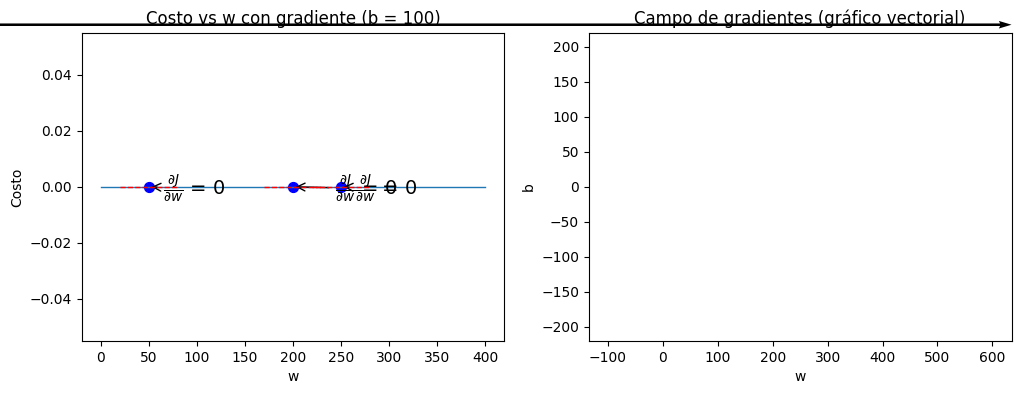

In [10]:
graficar_gradientes(x_train, y_train, calcular_costo, calcular_gradiente)
plt.show()

La gráfica a la izquierda de la celda de arriba muestra $\frac{\partial J(w,b)}{\partial w}$ que es la pendiente del costo relativo a $w$ en tres puntos. Las derivadas guian el descenso de gradiante hacia el mínimo de la función costo.

A la derecha, se muestra el campo de gradientes considerando ambos parámetros. El tamaño de las flechas refleja la magnitud del gradiente en ese punto. Notar que en realidad el gradiente apunta alejandose del mínimo. Sin embargo, el signo menos en el algoritmo de descenso de gradiente cambia el sentido y mueve los parámetros en la dirección que reduce el costo.

###  Descenso de gradiente
La siguiente celda define la función descenso de gradiente que será utilizada para ajustar los valores de $w$ y $b$.

In [11]:
def descenso_gradiente(datos, etiquetas, w_inicial, b_inicial, tasa_aprendizaje, iteraciones, funcion_costo, funcion_gradiente):
    """
    Realiza descenso del gradiente para ajustar los parámetros w y b.
    Actualiza w y b realizando el número de iteraciones indicadas con una
    tasa de aprendizaje específica.

    Parámetros:
      datos (ndarray (m,))         : Datos de entrada, m ejemplos
      etiquetas (ndarray (m,))     : Valores objetivo
      w_inicial, b_inicial (float) : Valores iniciales de los parámetros
      tasa_aprendizaje (float)     : Tasa de aprendizaje
      iteraciones (int)            : Número de iteraciones del algoritmo
      funcion_costo                : Función que calcula el costo
      funcion_gradiente            : Función que calcula los gradientes

    Retorna:
      w_final (float)              : Valor final del parámetro w
      b_final (float)              : Valor final del parámetro b
      historial_costos (list)      : Lista con el valor del costo por iteración
      historial_parametros (list)  : Lista con los valores de [w, b] por iteración
    """

    historial_costos = []
    historial_parametros = []

    w_actual = w_inicial
    b_actual = b_inicial

    for paso in range(iteraciones):
        grad_w, grad_b = funcion_gradiente(datos, etiquetas, w_actual, b_actual)

        # Actualizamos los parámetros
        w_actual = w_actual - tasa_aprendizaje * grad_w
        b_actual = b_actual - tasa_aprendizaje * grad_b

        # Guardamos historial si no es demasiado grande
        if paso < 100000:
            costo = funcion_costo(datos, etiquetas, w_actual, b_actual)
            historial_costos.append(costo)
            historial_parametros.append([w_actual, b_actual])

        # Imprimimos el estado cada cierta cantidad de iteraciones
        if paso % math.ceil(iteraciones / 10) == 0:
            print(f"Iteración {paso:4}: Costo {historial_costos[-1]:0.2e} ",
                  f"grad_w: {grad_w: 0.3e}, grad_b: {grad_b: 0.3e}  ",
                  f"w: {w_actual: 0.3e}, b: {b_actual: 0.5e}")

    return w_actual, b_actual, historial_costos, historial_parametros


## Entrenamiento

In [12]:
# inicializamos los parámetros
w_init = 0
b_init = 0
# definimos hyperparámetros
iterations = 5000
tasa_aprendizaje = 1.0e-2
# corremos descenso de gradiente
w_final, b_final, J_hist, p_hist = descenso_gradiente(x_train ,y_train, w_init, b_init, tasa_aprendizaje,
                                                    iterations, calcular_costo, calcular_gradiente)
print(f"(w,b) encontrados por el descenso de gradiente: ({w_final:8.4f},{b_final:8.4f})")

Iteración    0: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración  500: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración 1000: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración 1500: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración 2000: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración 2500: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración 3000: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración 3500: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración 4000: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.000e+00   w:  0.000e+00, b:  0.00000e+00
Iteración 4500: Costo 0.00e+00  grad_w:  0.000e+00, grad_b:  0.0

Vamos a superponer la linea encontrada con los puntos originales

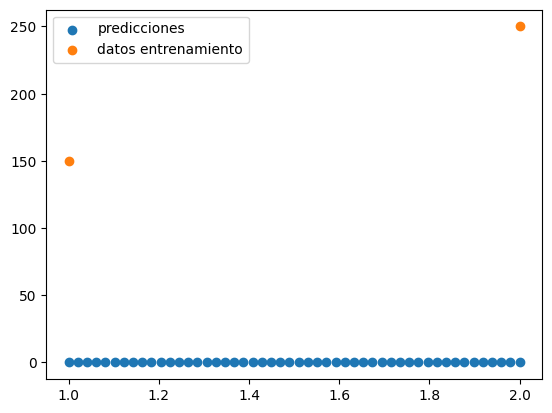

In [13]:
# primero calculamos muestras a lo largo de la linea encontrada por el algoritmo
muestras_x = np.linspace(x_train.min(), x_train.max())
muestras_y = w_final * muestras_x + b_final
plt.scatter(muestras_x, muestras_y, label='predicciones')
plt.scatter(x_train, y_train, label='datos entrenamiento')
plt.legend()

Como podemos observar en el grafico de arriba. El algoritmo de descenso de gradiente nos permitió encontrar los parametros w y b correctos para ajustar los dos ejemplos de entrenamiento.

Ahora vamos a crear un gráfico del costo frente a las iteraciones para observar el progreso en el descenso del gradiente. El costo debe disminuir siempre en ejecuciones exitosas.

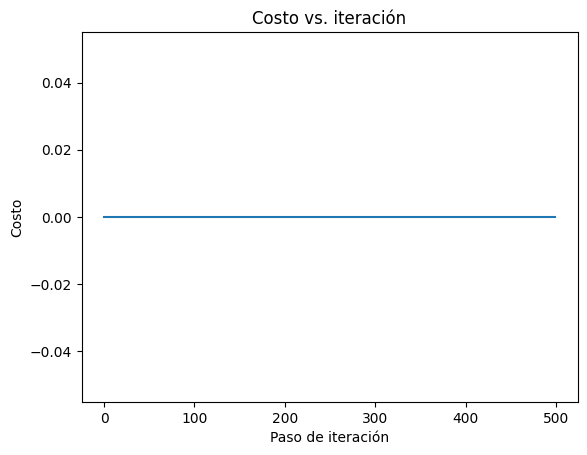

In [14]:
# Graficar costo. Cambia los valores de inicio y final de iteración para ver distintas partes del proceso.
iteracion_inicio = 0
iteracion_final = 500
plt.plot(J_hist[iteracion_inicio:iteracion_final])

plt.title("Costo vs. iteración")
plt.ylabel('Costo')
plt.xlabel('Paso de iteración')

plt.show()

## Predicciones

Ahora que has encontrado los valores óptimos para los parámetros $w$ y $b$, puedes utilizar el modelo para predecir los valores de las viviendas basándote en los parámetros aprendidos. Como era de esperarse, los valores predichos son casi iguales a los valores de entrenamiento para esas mismas viviendas. Además, el valor que no se incluyó en el entrenamiento está en línea con el valor esperado.

In [15]:
print(f"Predicción para un valor de x de 1.0  {w_final*1.0 + b_final:0.1f}")
print(f"Predicción para un valor de x de 1.5  {w_final*1.2 + b_final:0.1f}")
print(f"Predicción para un valor de x de 2.0  {w_final*2.0 + b_final:0.1f}")

Predicción para un valor de x de 1.0  0.0
Predicción para un valor de x de 1.5  0.0
Predicción para un valor de x de 2.0  0.0


## Visualización descenso del gradiente

La siguiente celda crea una visualización que muestra el progreso del descenso del gradiente durante su ejecución graficando el costo a lo largo de las iteraciones sobre un gráfico de contorno de la función de costo.

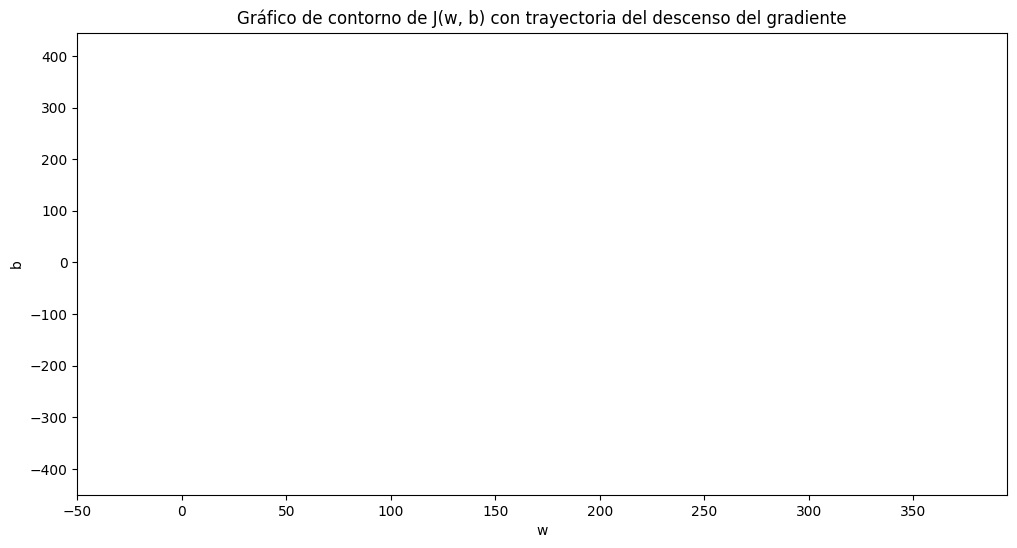

In [16]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
graficar_contorno_con_descenso(x_train, y_train, p_hist, ax, calcular_costo)

Arriba, las gráficas de contorno muestran el costo $J(w,b)$ para un rango de $w$ y $b$. Sobre ellas, usando flechas rojas se muestra el camino del descenso del gradiente. Por favor notar lo siguiente:
- La trayectoria avanza de forma constante (monótona) hacia su objetivo.
- Los pasos iniciales son mucho más grandes que los pasos cerca del objetivo

Actividad: Cambia el valor de la taza de aprendizaje y observa el impacto en el proceso de entrenamiento.